<a href="https://colab.research.google.com/github/MercyMoparthy/project-nlp-challenge/blob/main/NLPModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1: Baseline Model with Stemming + Logistic Regression

Set up a basic pipeline using manual text preprocessing and Logistic Regression.

## 🔧 Steps:
1. Import Librairies and load data (Assign columns name)

2. Preprocessing:

    - Remove punctuation and digits

    - Tokenize

    - Remove stopwords

    - Stemming (using NLTK’s PorterStemmer)

    - Join tokens back into a string

3. Vectorization:

    - TF-IDF Vectorization

4. Model:

    - Logistic Regression

5. Evaluation:

    - Accuracy, confusion matrix, classification report

6. Prediction for Testing Data

##  ✅ Purpose:
Establish a working pipeline and baseline score (~70-80% accuracy is expected here).

## 1. Import Librairies and load data

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from model_eval import save_model_results, save_trained_model

In [2]:
data = pd.read_csv("data/training_data_lowercase.csv", sep="\t", header=None, names=["label", "title"])
data.reset_index(drop=True, inplace=True)  # optional

data.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


## 2. Preprocessing:
* StopWords
* Tokenization
* Stemmer and Lemmatizer
* Removing Special Characters and Digits

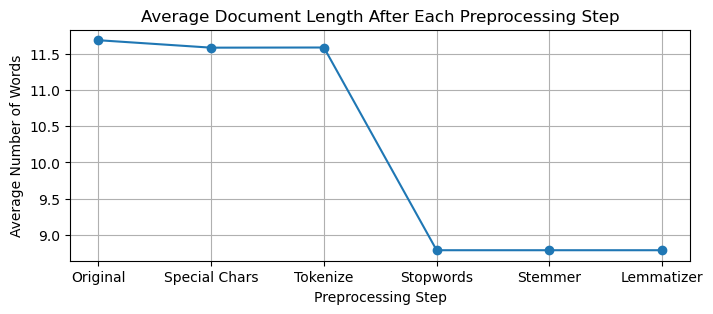

In [3]:
# Step 1: For plotting (intermediate results)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
special_removed = data['title'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
tokenized = special_removed.apply(word_tokenize)
no_stopwords = tokenized.apply(lambda tokens: [w for w in tokens if w.lower() not in stop_words])
stemmed = no_stopwords.apply(lambda tokens: [stemmer.stem(w) for w in tokens])
lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])

steps = [
    "Original",
    "Special Chars",
    "Tokenize",
    "Stopwords",
    "Stemmer",
    "Lemmatizer"
]
avg_lengths = [
    data['title'].apply(lambda x: len(x.split())).mean(),
    special_removed.apply(lambda x: len(x.split())).mean(),
    tokenized.apply(len).mean(),
    no_stopwords.apply(len).mean(),
    stemmed.apply(len).mean(),
    lemmatized.apply(len).mean()
]

plt.figure(figsize=(8,3))
plt.plot(steps, avg_lengths, marker='o')
plt.title("Average Document Length After Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Average Number of Words")
plt.grid(True)
plt.show()

In [4]:
import string
# Step 2: For final clean data (single function)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove special characters
    text = re.sub(r'\b\w\b', '', text) # remove single characters
    tokens = word_tokenize(text) # tokenization
    tokens = [w for w in tokens if w.lower() not in stop_words] # remove stop words
    tokens = [char for char in tokens if char not in string.punctuation and not char.isdigit()] # remove punctuations and digits
    tokens = [stemmer.stem(w) for w in tokens] # stemmerizing
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # lemmatizing
    return " ".join(tokens)

data["clean_title"] = data["title"].apply(preprocess_text)

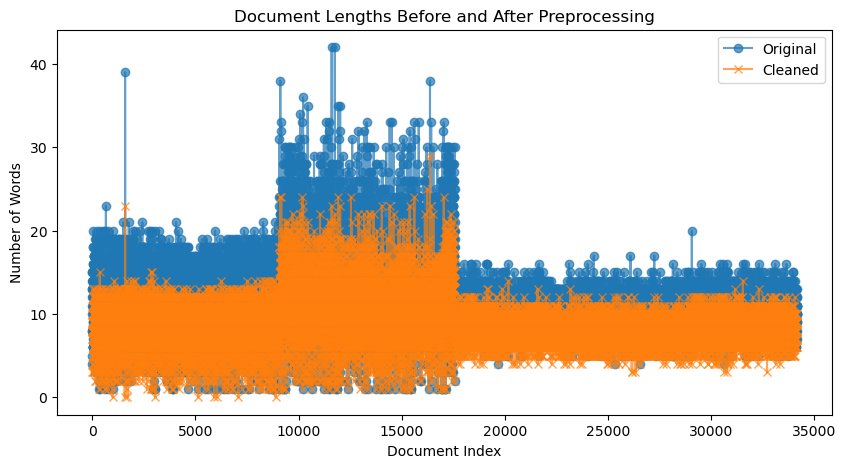

In [5]:
# Calculate document lengths before and after preprocessing
orig_lengths = data['title'].apply(lambda x: len(x.split()))
clean_lengths = data['clean_title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.plot(orig_lengths.values, label='Original', marker='o', alpha=0.7)
plt.plot(clean_lengths.values, label='Cleaned', marker='x', alpha=0.7)
plt.title('Document Lengths Before and After Preprocessing')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

Class Distribution

C:\Users\jeand\AppData\Local\Temp\ipykernel_40348\3775043527.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette=bar_colors)


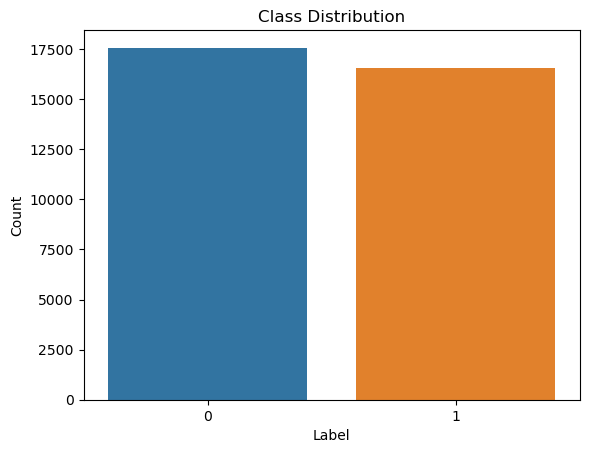

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
bar_colors = ['#1f77b4', '#ff7f0e']
sns.countplot(x='label', data=data, palette=bar_colors)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## 3. Train Split and Vectorization

Create a TF-IDF Representation

In [7]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')
x_tfidf = tfidf_vectorizer.fit_transform(data['title'])

print(x_tfidf.shape) 
print("TF-IDF Representation:\n", x_tfidf.toarray())

(34152, 18714)
TF-IDF Representation:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TF-IDF Vector Projection

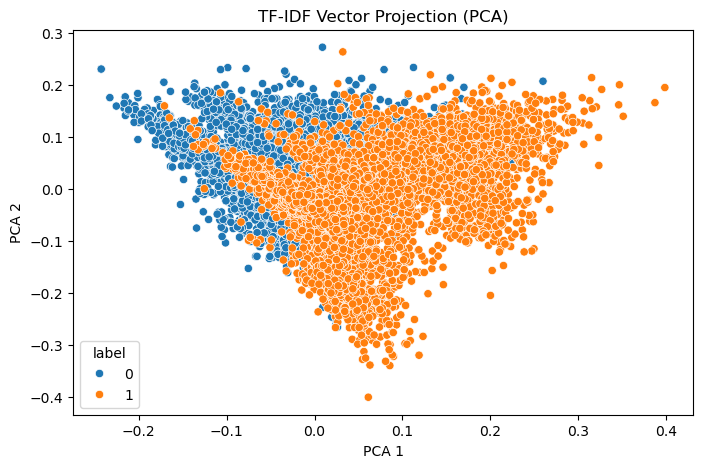

In [8]:
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_tfidf.toarray())

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['label'], palette='tab10')
plt.title('TF-IDF Vector Projection (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## 4. Logistic Regression Model

In [9]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time

X = x_tfidf
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
clf = LogisticRegression()
clf.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60

## 5. Evaluation

In [10]:
# Predict and evaluate
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
print("Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))
print(train_accuracy)
print(test_accuracy)

Accuracy: 0.9467135119309033
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3529
           1       0.94      0.95      0.95      3302

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831

0.963800739358003
0.9467135119309033


HeatMap

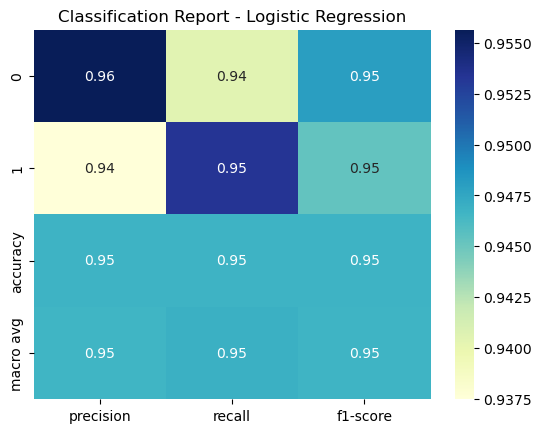

In [12]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, test_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report - Logistic Regression')
plt.show()

## 6. Confusion Matrix

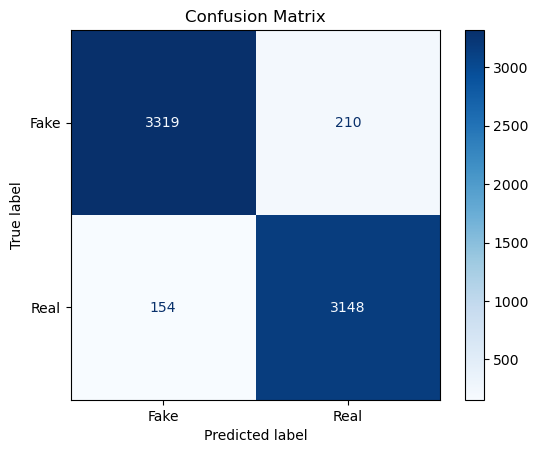

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the actual labels from new_data
true_labels = data['label']
cm = confusion_matrix(y_test, test_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 7. Testing Data

Preprocess data

In [14]:
new_testing_data = pd.read_csv('Data/testing_data_lowercase_nolabels.csv')
new_data = new_testing_data.to_csv('Data/Predicted_Data.csv', index=False)
predicted_data = pd.read_csv('data/Predicted_Data.csv')

In [15]:
# Read the predicted data as a CSV (tab-separated) and assign column names
predicted_data = pd.read_csv('Data/Predicted_Data.csv', sep='\t', header=None, names=["label", "title"])
# Check the result
print(predicted_data.head())

  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


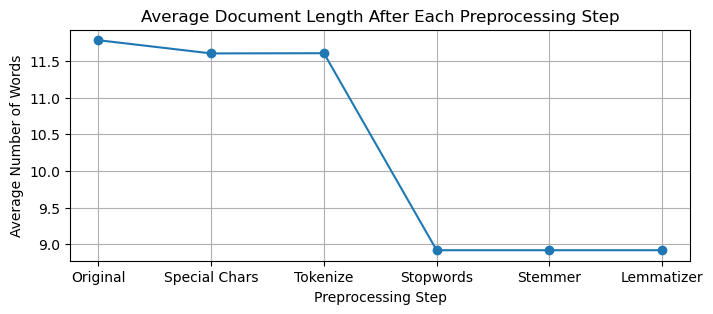

In [16]:
stop_words = set(stopwords.words('english'))
predicted_data['title'] = predicted_data['title'].astype(str)
# Ensure all titles are strings (replace NaN/float with empty string)
#titles = predicted_data['title'].fillna('').astype(str)

special_removed = predicted_data['title'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
tokenized = special_removed.apply(word_tokenize)
no_stopwords = tokenized.apply(lambda tokens: [w for w in tokens if w.lower() not in stop_words])
stemmed = no_stopwords.apply(lambda tokens: [stemmer.stem(w) for w in tokens])
lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])

steps = [
    "Original",
    "Special Chars",
    "Tokenize",
    "Stopwords",
    "Stemmer",
    "Lemmatizer"
]
avg_lengths = [
    predicted_data['title'].apply(lambda x: len(x.split())).mean(),
    special_removed.apply(lambda x: len(x.split())).mean(),
    tokenized.apply(len).mean(),
    no_stopwords.apply(len).mean(),
    stemmed.apply(len).mean(),
    lemmatized.apply(len).mean()
]

plt.figure(figsize=(8,3))
plt.plot(steps, avg_lengths, marker='o')
plt.title("Average Document Length After Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Average Number of Words")
plt.grid(True)
plt.show()

In [17]:
# Step 2: For final clean data (single function)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.lower() not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

predicted_data["clean_title"] = predicted_data["title"].apply(preprocess_text)

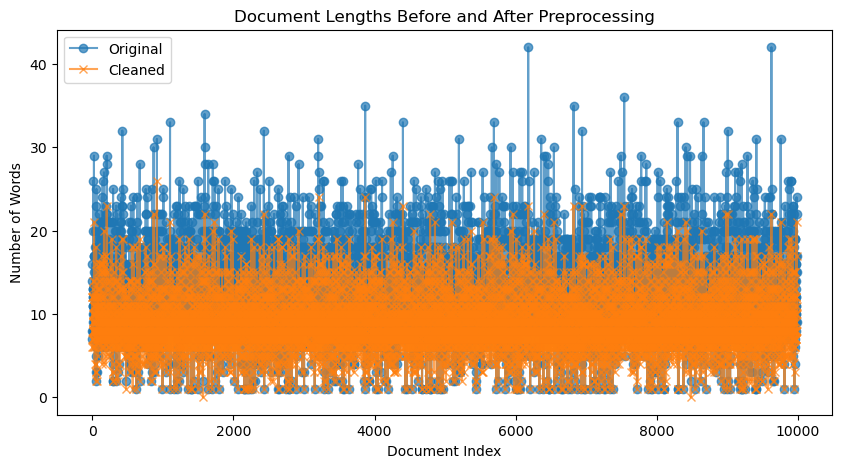

In [18]:
# Calculate document lengths before and after preprocessing
orig_lengths = predicted_data['title'].apply(lambda x: len(x.split()))
clean_lengths = predicted_data['clean_title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.plot(orig_lengths.values, label='Original', marker='o', alpha=0.7)
plt.plot(clean_lengths.values, label='Cleaned', marker='x', alpha=0.7)
plt.title('Document Lengths Before and After Preprocessing')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

In [19]:
# 1. Vectorize the clean titles using the same vectorizer as training
X_real_vec = tfidf_vectorizer.transform(predicted_data["clean_title"])

# 2. Predict labels using the trained Logistic Regression model
predicted_labels = clf.predict(X_real_vec)

# 3. Add predictions to the DataFrame as a new column (in memory only)
predicted_data["predicted_label"] = predicted_labels

# 4. Drop the 'clean_title' column before saving to file
output_data = predicted_data.drop(columns=["clean_title"])

# Overwrite the same file, keeping the original columns and adding the new one
output_data.to_csv('Data/Predicted_Data.csv', sep='\t', index=False)

# 4. (Optional) Show a sample
print(predicted_data[["title", "predicted_label"]].head())

                                               title  predicted_label
0  copycat muslim terrorist arrested with assault...                0
1  wow! chicago protester caught on camera admits...                0
2   germany's fdp look to fill schaeuble's big shoes                1
3  mi school sends welcome back packet warning ki...                0
4  u.n. seeks 'massive' aid boost amid rohingya '...                1


## Visualization of Predicted Values

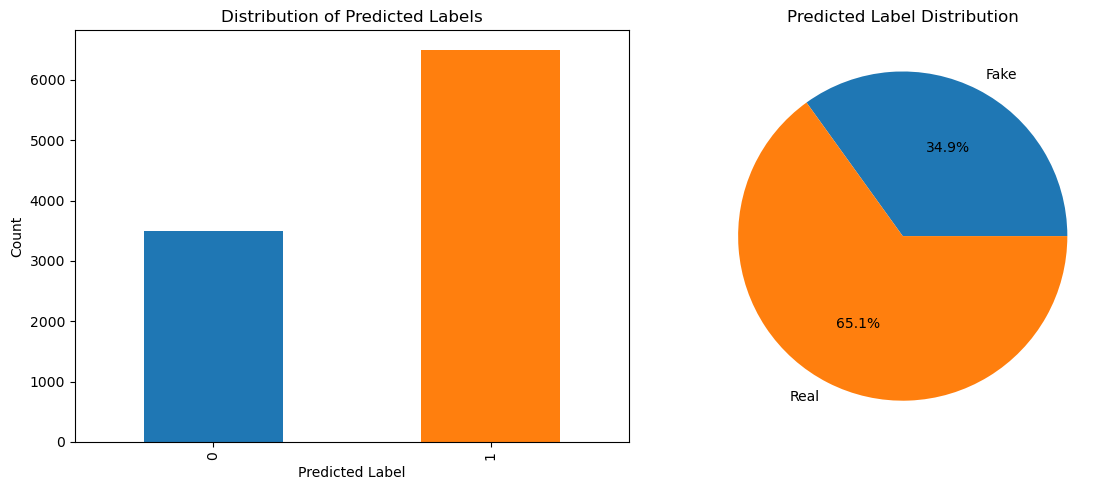

In [20]:
# Convert predictions to Series
pred_series = pd.Series(predicted_labels)
bar_colors = ['#1f77b4', '#ff7f0e']  # Example: blue for 0, orange for 1

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart (no change needed)
pred_series.value_counts().sort_index().plot(
    kind='bar',
    color=bar_colors,
    ax=axes[0]
)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Predicted Labels')

# Pie chart (let pandas use the correct labels)
pred_series.value_counts().sort_index().plot(
    kind='pie',
    autopct='%1.1f%%',
    labels=pred_series.value_counts().sort_index().index.map({0: 'Fake', 1: 'Real'}),
    colors=bar_colors,
    ax=axes[1]
)
axes[1].set_title('Predicted Label Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## Save Model with Metrics

In [21]:
# Save results using the model_eval module
save_model_results(
    model_name="NLPModel1_LoR",
    display_name="Logistic Regression",
    accuracy=test_accuracy, 
    training_time_minutes=training_time, 
    model_architecture="Logistic Regression with TF-IDF Vectorization",
    preprocessing_type="NLP Basic PreProcessing",
    train_accuracy=train_accuracy,
    classification_report=report
)
print("Model results saved successfully!")
print(f"Model:Logistic Regression + TF-IDF Vectorizer")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training Time: {training_time:.2f} minutes")

Results saved to results/NLPModel1_LoR_results.json
Model: Logistic Regression
Accuracy: 0.9467 (94.67%)
Training Time: 0.00 minutes
Model results saved successfully!
Model:Logistic Regression + TF-IDF Vectorizer
Training Accuracy: 0.9638
Test Accuracy: 0.9467
Training Time: 0.00 minutes


## Save trained model

In [22]:
save_trained_model(clf, model_name="NLPModel1_LoR")

✅ Model saved: trained_models\NLPModel1_LoR_20250529_174714.joblib


'trained_models\\NLPModel1_LoR_20250529_174714.joblib'